In [1]:
import torch.optim as optim
from utils import *
from model import *
import config
from train import *
from scipy.stats import truncnorm
import torch
from torchvision.datasets import CIFAR10
import torchvision.datasets as datasets

# Load weight

In [2]:
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)
dis = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))

In [3]:
gen_params = sum(p.numel() for p in gen.parameters())
print(f"Number parameters of Generator    : {gen_params}")
dis_params = sum(p.numel() for p in dis.parameters())
print(f"Number parameters of Discriminator: {dis_params}")

Number parameters of Generator    : 5772979
Number parameters of Discriminator: 6366529


In [4]:
load_checkpoint('../../weightCelebA//generator.pth', gen, opt_gen, config.LEARNING_RATE)
# generate_examples(gen, 3, root_path= 'fakeCeleba', n = 200)
load_checkpoint('../../weightCIFAR/generator.pth', gen, opt_gen, config.LEARNING_RATE)
# generate_examples(gen, 3, root_path= 'fakeCIFAR', n = 200)

=> Loading checkpoint
=> Loading checkpoint


In [5]:
import cv2
# Load image in LAB format
lab_img = cv2.imread('../fakeCeleba/saved_examples/img_1.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

# Convert LAB image to RGB
rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
print(type(rgb_img))
# plt.imshow(rgb_img)

<class 'numpy.ndarray'>


In [6]:
steps = [0,1,2,3,4]
alpha = 1

In [7]:
# Generate 1 anh duy nhat 
with torch.no_grad():
    generated_images = []
    noise = torch.tensor(truncnorm.rvs(-0.7, 0.7, size=(1, config.Z_DIM, 1, 1)),
                            device=config.DEVICE, dtype=torch.float32)
    img = gen(noise, alpha, steps[3])
    print(img.shape)
    generated_images.append(img)
    generated_images = torch.cat(generated_images, dim = 0)
    print(generated_images.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [8]:
# Load CelebA (real data)    
real_loader_CE, datasets = get_loader(4 * 2 ** steps[3], r"../../datasets/img_align_celeba")
real_Ce, labels = next(iter(real_loader_CE))

In [43]:
# def get_loader(namedata, image_size, root_path):
#     transform = transforms.Compose([                                                                                   
#             transforms.Resize((image_size, image_size)),
#             transforms.ToTensor(),
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.Normalize([0.5 for _ in range(config.CHANNELS_IMG)], [0.5 for _ in range(config.CHANNELS_IMG)],),]
#     )
#     batch_size = config.BATCH_SIZES[int(log2(image_size / 4))]
#     if namedata == "CIFAR10":
#         dataset = namedata(root = root_path, train=True,
#                                         download=True, transform=transform)
#     else:
#         dataset = datasets.ImageFolder(root_path, transform=transform)
#     loader = DataLoader(
#         dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=config.NUM_WORKERS,
#         pin_memory=True,
#     )
#     return loader, dataset

In [10]:
# Load CIFAR (real data)    
real_loader_C, dataset = get_loader_CIFAR(4 * 2 ** steps[3], r"../../datasets/cifar10/")
real_C, labels = next(iter(real_loader_C))

Files already downloaded and verified


In [11]:
from train import *
# Load generated images CelebA (fake data)
fake_loader_CE, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCeleba")
fake_CE, labels = next(iter(fake_loader_CE))

In [12]:
from train import *
# Load generated images CIFAR10 (fake data)
fake_loader_C, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCIFAR")
fake_C, labels = next(iter(fake_loader_C))

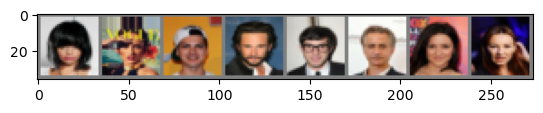

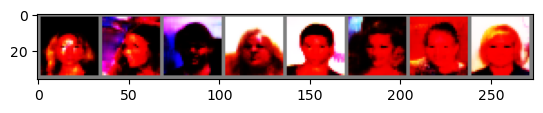

In [13]:
imshow(torchvision.utils.make_grid(real_Ce[:8]))
imshow(torchvision.utils.make_grid(fake_CE[:8]))

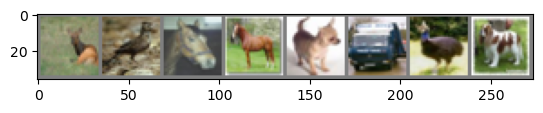

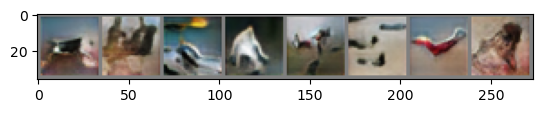

In [14]:
imshow(torchvision.utils.make_grid(real_C[:8]))
imshow(torchvision.utils.make_grid(fake_C[:8]))

In [15]:
print("Calculating Distribution for fake and real CelebA dataset: ")
means_Ce, std_Ce  = get_inception_score(real_Ce, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_Ce, means_Ce)
means_fake_CE, std_fake_CE = get_inception_score(fake_CE, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_fake_CE, means_fake_CE)

Calculating Distribution for fake and real CelebA dataset: 


/home/nyanmaruk/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nyanmaruk/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/nyanmaruk/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:18<00:00, 5.95MB/s] 
/home/nyanmaruk/Uni/Progressive_Growing_of_GAN/ProgressiveGAN/utils.py:123: UserWarning: Implicit dimension choice for sof

0.17803550702333668 1.4674039730779496
0.17612755275035227 1.4708555158005494


In [16]:
print("Calculating Distribution for fake and real CIFAR10 dataset: ")
means_C, std_C  = get_inception_score(real_C, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_Ce, means_Ce)
means_fake_C, std_fake_C  = get_inception_score(fake_C, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_fake_C, means_fake_C)

Calculating Distribution for fake and real CIFAR10 dataset: 
0.17803550702333668 1.4674039730779496
0.1749723853891037 1.537061688918464


In [17]:
def kl_divergence(mean1, mean2, std1, std2):

    kl = np.log(std2/std1) + (std1**2 + (mean1 - mean2)**2) / (2 * std2**2) - 0.5
    return kl.sum()

def inception_score(real_imgs, fake_imgs, batch_size=32):
    real_scores, real_std = get_inception_score(real_imgs, cuda=False, batch_size=batch_size, resize=True, splits= 8)
    fake_scores, fake_std = get_inception_score(fake_imgs, cuda=False, batch_size=batch_size, resize=True, splits= 8)
    kl = kl_divergence(real_scores, real_std, fake_scores, fake_std)
    is_score = np.exp(kl)
    return is_score

In [18]:
print("Calculating KL divergence for CelebA dataset: ")
kl_divergence(means_Ce, means_fake_CE, std_Ce, std_fake_CE)

Calculating KL divergence for CelebA dataset: 


0.0003089471790045373

In [19]:
print("Calculating KL divergence for CIFAR10 dataset: ")
kl_divergence(means_C, means_fake_C, std_C, std_fake_C)

Calculating KL divergence for CIFAR10 dataset: 


0.3100798889586862

In [20]:
print("Calculating Inception Score for CelebA dataset: ")
inception_score(real_Ce, fake_CE, batch_size=32)

Calculating Inception Score for CelebA dataset: 


4.389933470719937e+25

In [21]:
print("Calculating Inception Score for CIFAR10 dataset: ")
inception_score(real_C, fake_C, batch_size=32)

Calculating Inception Score for CIFAR10 dataset: 


4.627366246066858e+27

In [22]:
print("Calculating FID for CelebA dataset: ")
fid_score(means_Ce, means_fake_CE, std_Ce, std_fake_CE)

Calculating FID for CelebA dataset: 


2.0776697822721872

In [23]:
print("Calculating FID for CIFAR10 dataset: ")
fid_score(means_C, means_fake_C, std_C, std_fake_C)

Calculating FID for CIFAR10 dataset: 


2.214872990660614

In [25]:
import torchvision.models as models

critic = models.resnet18(pretrained=True)
critic.fc = torch.nn.Linear(512, 1)
critic.to(config.DEVICE)
opt_critic = optim.Adam(dis.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
load_checkpoint('../../weightCelebA/critic.pth', dis, opt_critic, config.LEARNING_RATE)
critic.eval()

=> Loading checkpoint


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
from sklearn.metrics import precision_score, recall_score

critic.to(config.DEVICE)

real_labels = torch.ones(64, dtype=torch.float32, device=config.DEVICE)
fake_labels = torch.zeros(64, dtype=torch.float32, device=config.DEVICE)


def Precision_Recall(real_loader, fake_loader, device):
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for images, _ in real_loader:
            images = images.to(device)
            outputs = critic(images).flatten()
            scores = torch.sigmoid(outputs).cpu().numpy().tolist()
            all_labels += [1] * len(scores)
            all_scores += scores

        for images, _ in fake_loader:
            images = images.to(device)
            outputs = critic(images).flatten()
            scores = torch.sigmoid(outputs).cpu().numpy().tolist()
            all_labels += [0] * len(scores)
            all_scores += scores

    precision = precision_score(all_labels, np.round(all_scores))
    recall = recall_score(all_labels, np.round(all_scores))
    return precision, recall


In [27]:
PC, RC = Precision_Recall(real_loader_C, fake_loader_C, device= config.DEVICE)
PCE, RCE = Precision_Recall(real_loader_CE, fake_loader_CE, device= config.DEVICE)

In [28]:
print(PC, RC)
print(PCE, RCE)

0.9969179041748389 0.28464
0.997827661115134 0.01496508508812893
